In [40]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
import sys
from tensorflow.keras import layers
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

tf.keras.backend.set_floatx('float64')

np.set_printoptions(threshold=sys.maxsize)

# CIFAR 10 dataset shape = (32, 32, 3)
IMAGE_SIZE = 32

In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# train / test data normalization
# data reshape ( node, feature )
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, IMAGE_SIZE ** 2, 3)
x_test = x_test.reshape(-1, IMAGE_SIZE ** 2, 3)

In [20]:
M = IMAGE_SIZE ** 2
x = np.linspace(0, 1, IMAGE_SIZE, dtype=np.float32)
y = np.linspace(0, 1, IMAGE_SIZE, dtype=np.float32)
    # meshgrid를 통해 행렬을 생성
xx, yy = np.meshgrid(x, y)
    # 784, 2 크기의 array를 생성
z = np.empty((M, 2), np.float32)
    # 아까 meshgrid를 통해 생성한 array를 평평하게 펴서 z에 넣음
z[:, 0] = xx.reshape(M)
z[:, 1] = yy.reshape(M)

In [21]:
from sklearn.neighbors import kneighbors_graph

# array z를 통해 8개의 이웃을 갖는 희소 행렬을 반환
# 유클리드 거리를 기준으로 계산거리를 기준으로 계산
A_mat = kneighbors_graph(z, 8).toarray()

In [22]:
print(x_train.shape, x_test.shape, A_mat.shape)
print(y_train.shape, y_test.shape)

(50000, 1024, 3) (10000, 1024, 3) (1024, 1024)
(50000, 1) (10000, 1)


In [23]:
# Graph Convolution Layer를 정의

def graph_conv(_X, _A, output_dim):
    X = tf.keras.layers.Dense(units=output_dim, use_bias=True, kernel_regularizer=l2(l2_reg))(_X)
    output = tf.matmul(_A, X)
    output = tf.keras.activations.relu(output)
    return output

In [29]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate
batch_size = 32       # Batch size
epochs = 10        # Number of training epochs

In [25]:
N = x_train.shape[-2]    # Number of nodes in the graphs
F = x_train.shape[-1]    # Node features dimensionality
n_out = 10               # Dimension of the target

print(N, F)

1024 3


In [34]:
# Input shape is Node x Feature
# Feature matrix
X_in = Input(shape=(N, F))

# Graph Conv dimension 64, 128, 256
# Conv / Activation / BatchNorm
graph_conv_1 = graph_conv(X_in, A_mat, 64)
batch_norm1 = tf.keras.layers.BatchNormalization()(graph_conv_1)

graph_conv_2 = graph_conv(batch_norm1, A_mat, 128)
batch_norm2 = tf.keras.layers.BatchNormalization()(graph_conv_2)

graph_conv_3 = graph_conv(batch_norm2, A_mat, 256)
batch_norm3 = tf.keras.layers.BatchNormalization()(graph_conv_3)

flatten = Flatten()(batch_norm3)

# fully connected layer 512, 256, 128, 10 
# Dense / BatchNorm / Dropout
fc = Dense(512, activation='relu')(flatten)
batch_norm4 = tf.keras.layers.BatchNormalization()(fc)
drop1 = tf.keras.layers.Dropout(0.25)(batch_norm4)

fc2 = Dense(256, activation='relu')(drop1)
batch_norm5 = tf.keras.layers.BatchNormalization()(fc2)
drop2 = tf.keras.layers.Dropout(0.25)(batch_norm5)

fc3 = Dense(128, activation='relu')(drop2)
batch_norm6 = tf.keras.layers.BatchNormalization()(fc3)
drop3 = tf.keras.layers.Dropout(0.25)(batch_norm6)

output = Dense(n_out)(drop3)

In [35]:
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(lr=learning_rate)

# 최하단 Dense layer에서 activation을 주지 않았기 때문에 from_logits 매개변수를 True로 지정
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "functional_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1024, 3)]         0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024, 64)          256       
_________________________________________________________________
tf_op_layer_BatchMatMulV2_6  [(None, 1024, 64)]        0         
_________________________________________________________________
tf_op_layer_Relu_6 (TensorFl [(None, 1024, 64)]        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 64)          256       
_________________________________________________________________
dense_13 (Dense)             (None, 1024, 128)         8320      
_________________________________________________________________
tf_op_layer_BatchMatMulV2_7  [(None, 1024, 128)]     

In [37]:
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,)

Epoch 1/10
1563/1563 [==============================] - 788s 504ms/step - loss: 1.8376 - accuracy: 0.3909
Epoch 2/10
1563/1563 [==============================] - 815s 521ms/step - loss: 1.5342 - accuracy: 0.4735
Epoch 3/10
1563/1563 [==============================] - 805s 515ms/step - loss: 1.4512 - accuracy: 0.4978
Epoch 4/10
1563/1563 [==============================] - 801s 513ms/step - loss: 1.3944 - accuracy: 0.5185
Epoch 5/10
1563/1563 [==============================] - 827s 529ms/step - loss: 1.3526 - accuracy: 0.5349
Epoch 6/10
1563/1563 [==============================] - 841s 538ms/step - loss: 1.3067 - accuracy: 0.5512
Epoch 7/10
1563/1563 [==============================] - 856s 547ms/step - loss: 1.2719 - accuracy: 0.5638
Epoch 8/10
1563/1563 [==============================] - 798s 511ms/step - loss: 1.2086 - accuracy: 0.5873
Epoch 9/10
1563/1563 [==============================] - 802s 513ms/step - loss: 1.1879 - accuracy: 0.5949
Epoch 10/10
1563/1563 [=======================

In [38]:
print('Evaluating model.')
eval_results = model.evaluate(x_test,
                              y_test,
                              batch_size=batch_size)
print('Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

Evaluating model.
313/313 [==============================] - 61s 196ms/step - loss: 1.2774 - accuracy: 0.5680
Test loss: 1.2774122202779419
Test acc: 0.568


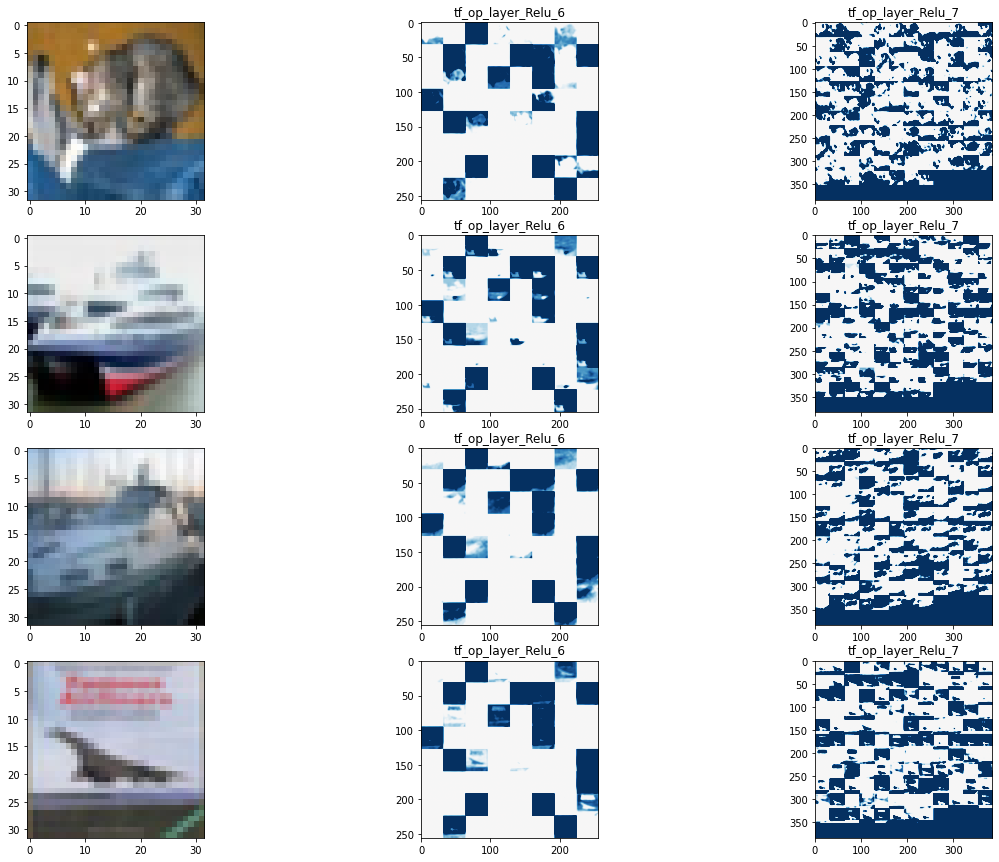

In [39]:
import matplotlib.pyplot as plt
from skimage.util import montage

i_model = Model(inputs=X_in, outputs=[graph_conv_1, graph_conv_2])
gc1_out, gc2_out = i_model.predict(x_test[:32])

fig, m_axs = plt.subplots(4, 3, figsize=(20, 15))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(x_test[i].reshape((32, 32, 3)))
    gc_stack = gc1_out[i].reshape((32, 32, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax2.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax2.set_title(i_model.output_names[0])
    gc_stack = gc2_out[i].reshape((32, 32, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax3.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax3.set_title(i_model.output_names[1])